In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import json
import warnings
warnings.filterwarnings("ignore")
from scipy.optimize import curve_fit
import itertools
from sklearn.metrics import mean_squared_log_error

from utils.model import hill_activation, hill_activation_single, hill_activation_and, random_search
from utils.helper import generate_data_at_t

In [2]:
aras = [0, 0.8125, 3.25, 13]
ohc14s = [0, 2.5, 5, 10]
sals = [0, 25, 50, 100]

In [3]:
def plot_induction_states(data, gates, row=2, col=3):
    
    ys = []
    f, axs = plt.subplots(row, col, sharex=False, sharey=False, figsize=(col*6, row*3))
    axr = axs.ravel()
    x = [format(x, '0{}b'.format(3)) for x in list(range(2**3))]
    for i, ax in enumerate(axr):
        if i < len(gates):
            y = data[filter(lambda x: x.startswith(gates[i]), data.index)]
            ys.append(y)
            dr = y.iloc[-1]/y[:-1].max()
            ax.bar(x, y)
            ax.set_title('{} (DR={})'.format(gates[i], np.round(dr, 2)))
        else:
            ax.set_visible(False)
    plt.tight_layout()
    sns.despine()
    return ys

def plot_agg_induction_states(data, gates, row=2, col=3):
    
    f, axs = plt.subplots(row, col, sharex=False, sharey=False, figsize=(col*6, row*3))
    axr = axs.ravel()
    x = [format(x, '0{}b'.format(3)) for x in list(range(2**3))]
    for i, ax in enumerate(axr):
        if i < len(gates):
            y = data[i].T
            y.columns = x
            dr = np.mean(y.iloc[:, -1]/y.iloc[:, :-1].max(axis=1))
            sns.barplot(data=y, color='#85b2bb', ax=ax)
            ax.set_title('{} (DR={})'.format(gates[i], np.round(dr, 2)))
        else:
            ax.set_visible(False)
    plt.tight_layout()
    sns.despine()

In [4]:
def generate_matrix(samples_t, on_states=[3, 3, 3]):
    
    induction_matrix = samples_t.reset_index()
    induction_matrix['ara'] = induction_matrix['name'].str[-3].astype(int)
    induction_matrix['ohc14'] = induction_matrix['name'].str[-2].astype(int)
    induction_matrix['sal'] = induction_matrix['name'].str[-1].astype(int)
    induction_matrix['ara_'] = induction_matrix['ara'].map({a:b for a, b in zip(list(range(len(aras))), aras)})
    induction_matrix['ohc14_'] = induction_matrix['ohc14'].map({a:b for a, b in zip(list(range(len(ohc14s))), ohc14s)})
    induction_matrix['sal_'] = induction_matrix['sal'].map({a:b for a, b in zip(list(range(len(sals))), sals)})

    max_induction = induction_matrix[((induction_matrix['ara']==0) | (induction_matrix['ara']==on_states[0])) &
                                 ((induction_matrix['ohc14']==0) | (induction_matrix['ohc14']==on_states[1])) &
                                 ((induction_matrix['sal']==0) | (induction_matrix['sal']==on_states[2]))].set_index('name').iloc[:, 0]
    
    return induction_matrix, max_induction

[('A', 'sample'), ('B', 'positive')]


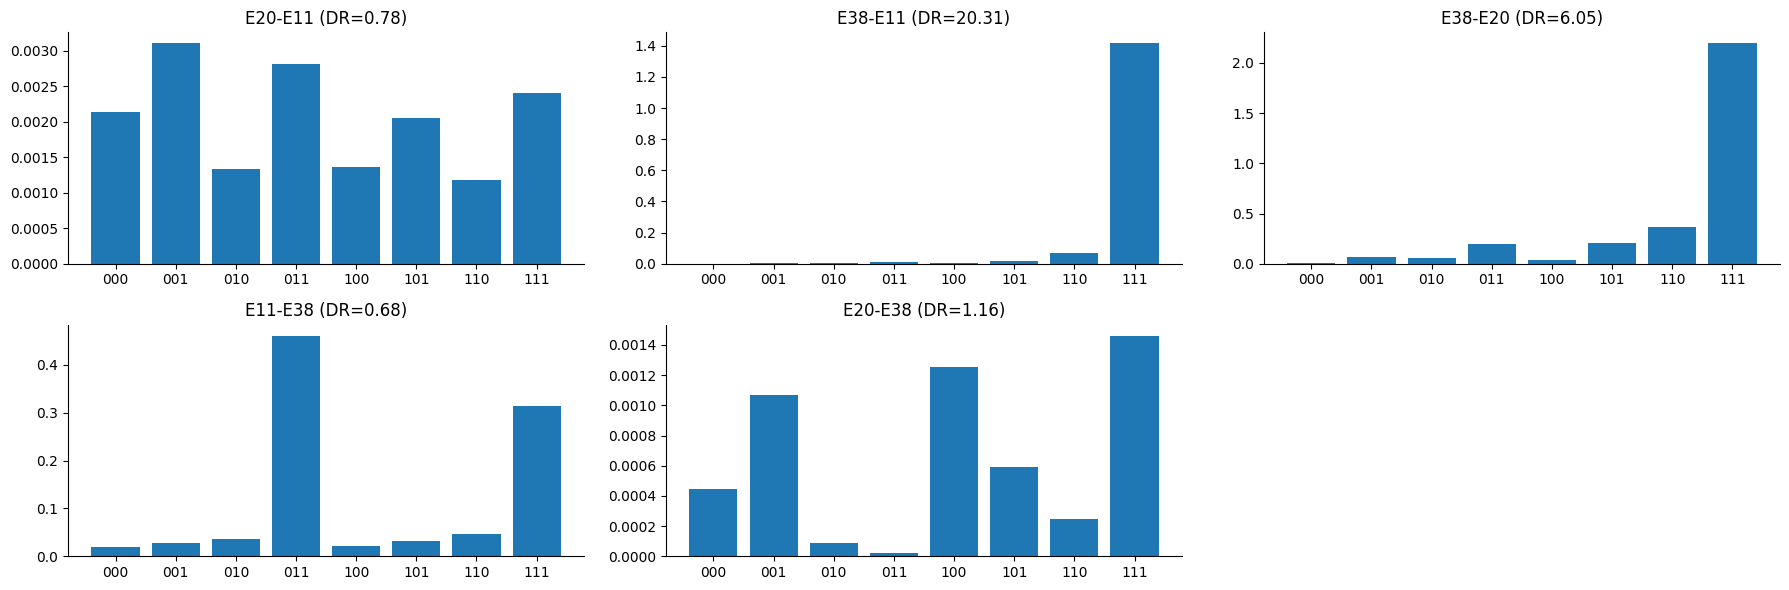

In [11]:
folder = '039-3i-AND-gates'
samples_t = generate_data_at_t(folder, 'raw', 'plate_map', kind='3-input on-off')[0]
gates = ['E20-E11', 'E38-E11', 'E38-E20', 'E11-E38', 'E20-E38']
ys1 = plot_induction_states(samples_t, gates)

[('A', 'sample'), ('B', 'positive')]


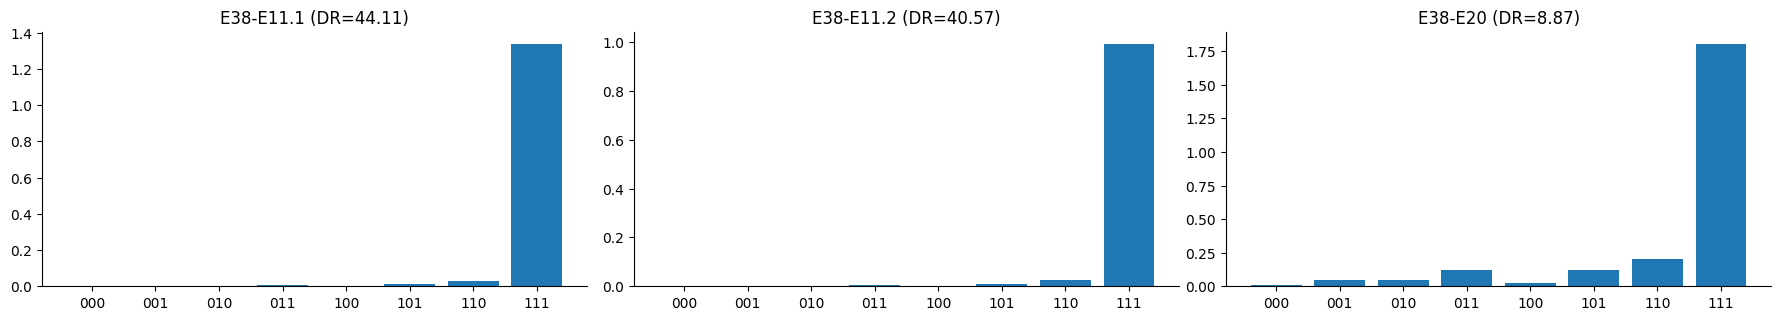

In [6]:
folder = '040-3i-AND-gates-induction-matrix-rep1'
samples_t = generate_data_at_t(folder, 'raw', 'plate_map', kind='3-input on-off')[0]
gates = ['E38-E11.1', 'E38-E11.2', 'E38-E20']    
ys2 = plot_induction_states(samples_t, gates)

[('A', 'sample'), ('B', 'positive')]


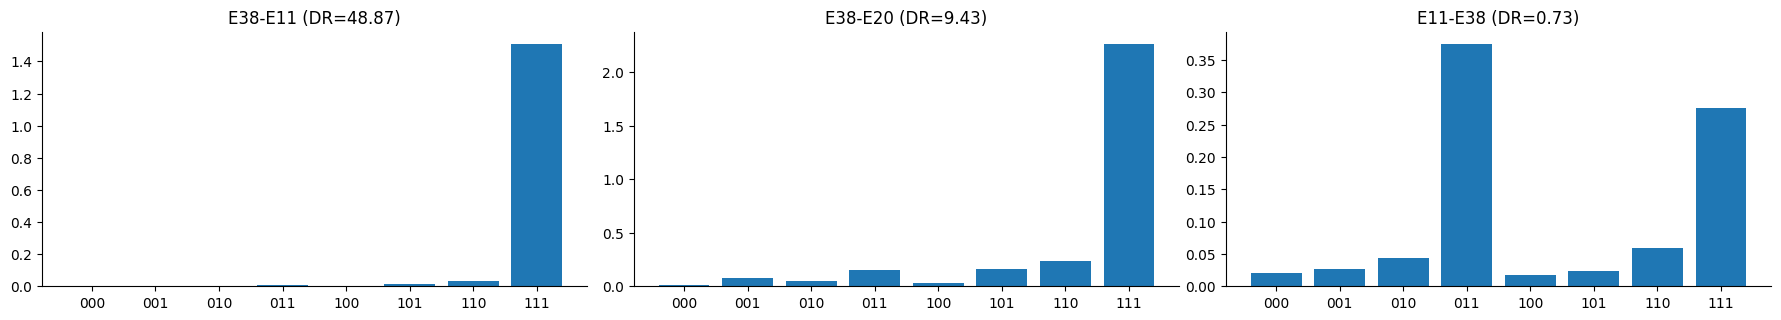

In [7]:
folder = '041-3i-AND-gates-induction-matrix-rep2'
samples_t = generate_data_at_t(folder, 'raw', 'plate_map', kind='3-input on-off')[0]
gates = ['E38-E11', 'E38-E20', 'E11-E38']
ys3 = plot_induction_states(samples_t, gates)

[('A', 'sample'), ('B', 'positive')]


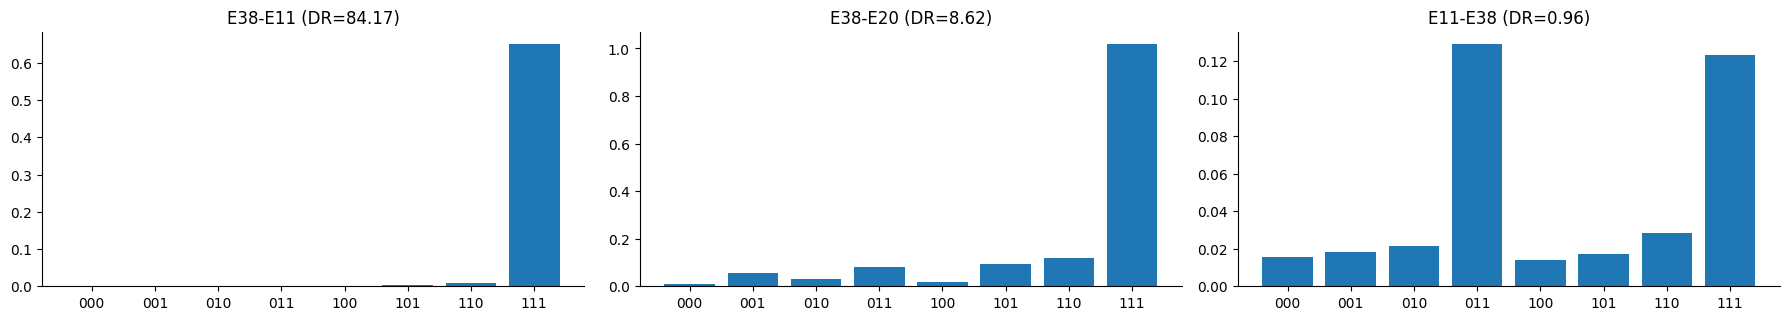

In [8]:
folder = '045-3i-AND-gates-induction-matrix-fixed-1'
samples_t = generate_data_at_t(folder, 'raw', 'plate_map', kind='3-input on-off', single_timepoint=True)[0]
gates = ['E38-E11', 'E38-E20', 'E11-E38']
ys4 = plot_induction_states(samples_t, gates)

[('A', 'sample'), ('B', 'positive')]


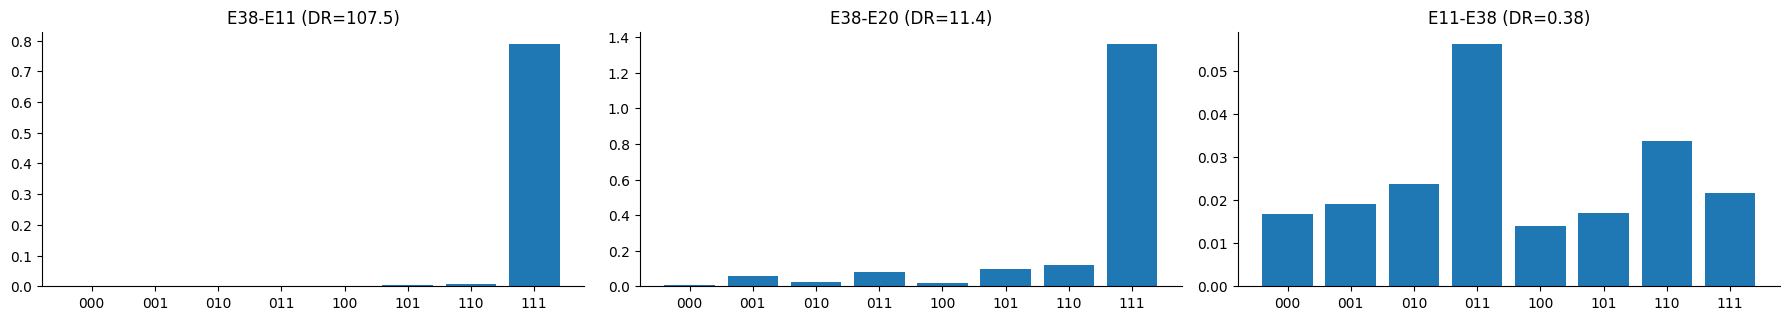

In [9]:
folder = '046-3i-AND-gates-induction-matrix-fixed-2'
samples_t = generate_data_at_t(folder, 'raw', 'plate_map', kind='3-input on-off', single_timepoint=True)[0]
gates = ['E38-E11', 'E38-E20', 'E11-E38']
ys4 = plot_induction_states(samples_t, gates)

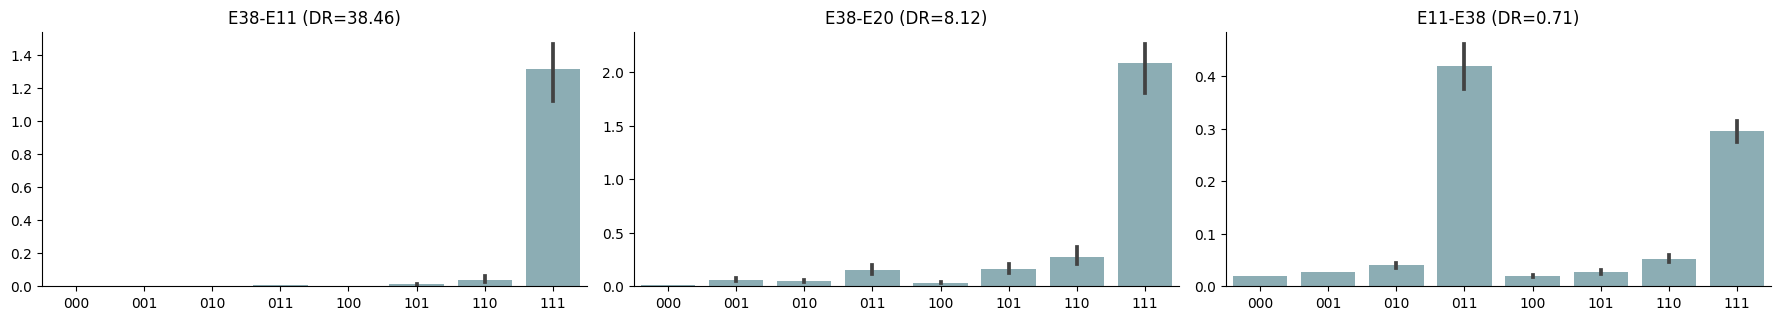

In [10]:
agg_gates = ['E38-E11', 'E38-E20', 'E11-E38']
agg_data = []
agg_data.append(pd.concat([i.reset_index(drop=True) for i in [ys1[1], ys2[0], ys2[1], ys3[0]]], axis=1))
agg_data.append(pd.concat([i.reset_index(drop=True) for i in [ys1[2], ys2[2], ys3[1]]], axis=1))
agg_data.append(pd.concat([i.reset_index(drop=True) for i in [ys1[3], ys3[2]]], axis=1))
plot_agg_induction_states(agg_data, agg_gates)

#### Induction Matrix

[('A', 'sample'), ('B', 'positive')]


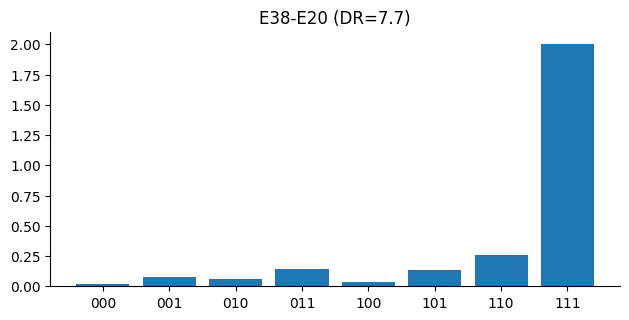

In [21]:
folder = '048-3i-AND-gates-induction-matrix-circuit-4'
samples_t = generate_data_at_t(folder, 'raw', 'plate_map_induction', kind='3-input induction matrix')[0]
induction_matrix, max_induction = generate_matrix(samples_t)
gates = ['E38-E20']
ym3 = plot_induction_states(max_induction, gates)
induction_matrix.to_csv('datasets/e38-e20-8h.csv', index=False)

In [22]:
induction_matrix

,name,8 h,ara,ohc14,sal,ara_,ohc14_,sal_
0,E38-E20_000,0.021430,0,0,0,0.0000,0.0,0
1,E38-E20_001,0.076855,0,0,1,0.0000,0.0,25
2,E38-E20_002,0.061890,0,0,2,0.0000,0.0,50
3,E38-E20_003,0.078630,0,0,3,0.0000,0.0,100
4,E38-E20_010,0.061999,0,1,0,0.0000,2.5,0
5,E38-E20_011,0.122282,0,1,1,0.0000,2.5,25
6,E38-E20_012,0.115991,0,1,2,0.0000,2.5,50
7,E38-E20_013,0.149297,0,1,3,0.0000,2.5,100
8,E38-E20_020,0.081888,0,2,0,0.0000,5.0,0
9,E38-E20_021,0.149666,0,2,1,0.0000,5.0,25


[('A', 'sample'), ('B', 'positive')]


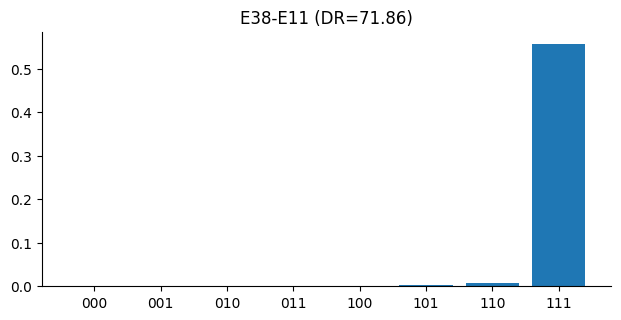

In [19]:
folder = '045-3i-AND-gates-induction-matrix-fixed-1'
samples_t = generate_data_at_t(folder, 'raw', 'plate_map_induction', kind='3-input induction matrix', single_timepoint=True)[0]
induction_matrix, max_induction = generate_matrix(samples_t)
gates = ['E38-E11']
ym2 = plot_induction_states(max_induction, gates)
induction_matrix.to_csv('datasets/e38-e11-8h.csv', index=False)

[('A', 'sample'), ('B', 'positive')]


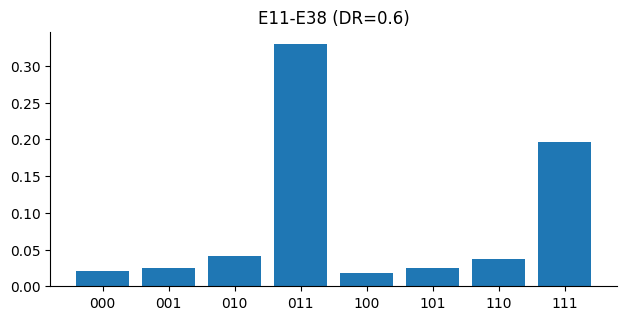

In [20]:
folder = '041-3i-AND-gates-induction-matrix-rep2'
samples_t = generate_data_at_t(folder, 'raw', 'plate_map_induction', kind='3-input induction matrix')[0]
induction_matrix, max_induction = generate_matrix(samples_t)
gates = ['E11-E38']
ym1 = plot_induction_states(max_induction, gates)
induction_matrix.to_csv('datasets/e11-e38-8h.csv', index=False)

In [ ]:
def generate_samples_at_t(folder, kind='3-input on-off', fluo_idx=3, rpu=True, h=8, single_measurement=False):
    
    raw_data = setup_header(pd.read_csv('datasets/experiment/{}/raw.csv'.format(folder)))
    plate_map = 'plate_map' if kind=='3-input on-off' else 'plate_map_induction'
    sample_map = read_map(pd.read_csv('datasets/experiment/{}/{}.csv'.format(folder, plate_map)))

    group = 'B'
    contents = ['Sample', 'Blank', 'Negative control']
    all_datas = []
    for content in contents:
        datas = generate_data(raw_data[(raw_data['Group']==group) & (raw_data['Content'].str.startswith(content))],
                              sample_map, content, kind=kind)
        all_datas.append(datas)
        
    #print(raw_data)

    group = 'A'
    contents = ['Positive control', 'Blank', 'Negative control']
    all_ctrls = []
    for content in contents:
        datas = generate_data(raw_data[(raw_data['Group']==group) & (raw_data['Content'].str.startswith(content))],
                              sample_map, content, kind=kind)
        all_ctrls.append(datas)
    
    od_idx = 0
    timepoint = 3 * h
    if rpu:
        samples = get_pos_ctrl_corrected([all_datas[0][fluo_idx], all_datas[1][fluo_idx], all_datas[2][fluo_idx],
                                          all_datas[0][od_idx], all_datas[1][od_idx], all_datas[2][od_idx]],
                                         [all_ctrls[0][fluo_idx], all_ctrls[1][fluo_idx], all_ctrls[2][fluo_idx],
                                          all_ctrls[0][od_idx], all_ctrls[1][od_idx], all_ctrls[2][od_idx]])
    else:
        samples = get_neg_ctrl_corrected([all_datas[0][fluo_idx], all_datas[1][fluo_idx], all_datas[2][fluo_idx],
                                          all_datas[0][od_idx], all_datas[1][od_idx], all_datas[2][od_idx]])
    if not single_measurement:
        samples_t = samples.iloc[timepoint]
    else:
        samples_t = samples.mean()
        
    return samples_t

### ON-OFF Induction States

In [ ]:
folder = '039-3i-AND-gates'
samples_t = generate_samples_at_t(folder, kind='3-input on-off')
gates = ['E20-E11', 'E38-E11', 'E38-E20', 'E11-E38', 'E20-E38']
ys1 = plot_induction_states(samples_t, gates)

In [ ]:
folder = '040-3i-AND-gates-induction-matrix-rep1'
samples_t = generate_samples_at_t(folder, kind='3-input on-off')
gates = ['E38-E11.1', 'E38-E11.2', 'E38-E20']    
ys2 = plot_induction_states(samples_t, gates)

In [ ]:
folder = '041-3i-AND-gates-induction-matrix-rep2'
samples_t = generate_samples_at_t(folder, kind='3-input on-off')
gates = ['E38-E11', 'E38-E20', 'E11-E38']
ys3 = plot_induction_states(samples_t, gates)

In [ ]:
folder = '045-3i-AND-gates-induction-matrix-fixed-1'
samples_t = generate_samples_at_t(folder, kind='3-input on-off', single_measurement=True)
gates = ['E38-E11', 'E38-E20', 'E11-E38']
ys4 = plot_induction_states(samples_t, gates)

In [ ]:
folder = '046-3i-AND-gates-induction-matrix-fixed-2'
samples_t = generate_samples_at_t(folder, kind='3-input on-off', single_measurement=True)
gates = ['E38-E11', 'E38-E20', 'E11-E38']
ys4 = plot_induction_states(samples_t, gates)

In [ ]:
folder = '050-3K3-optimized-3i-AND-gates'
samples_t = generate_samples_at_t(folder, kind='3-input on-off')
gates = ['E11-E38.1', 'E11-E38.2', 'E11-E38.3', 'E11-E38.4', 'E11-E38.5', 'E11-E38.6']
ys5 = plot_induction_states(samples_t, gates)

In [ ]:
agg_gates = ['E11-E38 - ind. recommendation #1', 'E11-E38 - ind. recommendation #2']
agg_data = []
agg_data.append(pd.concat([i.reset_index(drop=True) for i in [ys5[0], ys5[1], ys5[2]]], axis=1))
agg_data.append(pd.concat([i.reset_index(drop=True) for i in [ys5[3], ys5[4], ys5[5]]], axis=1))
plot_agg_induction_states(agg_data, agg_gates)

#### Aggregated Data

In [ ]:
agg_gates = ['E38-E11', 'E38-E20', 'E11-E38']
agg_data = []
agg_data.append(pd.concat([i.reset_index(drop=True) for i in [ys1[1], ys2[0], ys2[1], ys3[0]]], axis=1))
agg_data.append(pd.concat([i.reset_index(drop=True) for i in [ys1[2], ys2[2], ys3[1]]], axis=1))
agg_data.append(pd.concat([i.reset_index(drop=True) for i in [ys1[3], ys3[2]]], axis=1))
plot_agg_induction_states(agg_data, agg_gates)

After a week of storing the inducer plate.

In [ ]:
agg_gates = ['E38-E11', 'E38-E20', 'E11-E38']
agg_data = []
agg_data.append(pd.concat([i.reset_index(drop=True) for i in [ys3[0], ys4[0]]], axis=1))
agg_data.append(pd.concat([i.reset_index(drop=True) for i in [ys3[1], ys4[1]]], axis=1))
agg_data.append(pd.concat([i.reset_index(drop=True) for i in [ys3[2], ys4[2]]], axis=1))
plot_agg_induction_states(agg_data, agg_gates)

### Induction Matrix

#### Check on-off states

In [ ]:
folder = '041-3i-AND-gates-induction-matrix-rep2'
samples_t = generate_samples_at_t(folder, kind='3-input induction matrix')
induction_matrix, max_induction = generate_matrix(samples_t)
gates = ['E11-E38']
ym1 = plot_induction_states(max_induction, gates)

Leakiness can be reduced by reducing some of the inducers.

In [ ]:
induction_matrix, max_induction = generate_matrix(samples_t, on_states=[1, 3, 2])
ym1 = plot_induction_states(max_induction, gates)

In [ ]:
folder = '045-3i-AND-gates-induction-matrix-fixed-1'
samples_t = generate_samples_at_t(folder, kind='3-input induction matrix', single_measurement=True)
induction_matrix, max_induction = generate_matrix(samples_t)
gates = ['E38-E11']
ym2 = plot_induction_states(max_induction, gates)

In [ ]:
#weird result - just omit
folder = '046-3i-AND-gates-induction-matrix-fixed-2'
samples_t = generate_samples_at_t(folder, kind='3-input induction matrix', single_measurement=True)
induction_matrix, max_induction = generate_matrix(samples_t)
gates = ['E38-E20']
ym3 = plot_induction_states(max_induction, gates)

In [ ]:
folder = '047-3i-AND-gates-induction-matrix-circuit-5'
samples_t = generate_samples_at_t(folder, kind='3-input induction matrix')
induction_matrix, max_induction = generate_matrix(samples_t, [1, 3, 2])
gates = ['E11-E38']
ym4 = plot_induction_states(max_induction, gates)

In [ ]:
folder = '048-3i-AND-gates-induction-matrix-circuit-4'
samples_t = generate_samples_at_t(folder, kind='3-input induction matrix')
induction_matrix, max_induction = generate_matrix(samples_t)
gates = ['E38-E20']
ym5 = plot_induction_states(max_induction, gates)

#### Machine Learning

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, KFold

In [ ]:
X = induction_matrix[['ara', 'ohc14', 'sal']]
y = induction_matrix.iloc[:, 1]
regr = RandomForestRegressor()
cross_val_score(regr, X, y, scoring='r2', cv=KFold(shuffle=True))

In [ ]:
X = induction_matrix[['ara_', 'ohc14_', 'sal_']]
y = induction_matrix.iloc[:, 1]
regr = RandomForestRegressor()
cross_val_score(regr, X, y, scoring='r2', cv=KFold(shuffle=True))